In [47]:
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, r2_score

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os

In [48]:
train = pd.read_csv('dataset/train.csv')
test= pd.read_csv('dataset/test.csv')
train.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,Mother's age,Father's age,Institute Name,Location of Institute,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Test 1,Test 2,Test 3,Test 4,Test 5,Parental consent,Follow-up,Gender,Birth asphyxia,Autopsy shows birth defect (if applicable),Place of birth,Folic acid details (peri-conceptional),H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,NaN,NaN,Boston Specialty & Rehabilitation Hospital,"55 FRUIT ST\nCENTRAL, MA 02114\n(42.3624748574...",Alive,Normal (30-60),Normal,0.0,NaN,NaN,1.0,0.0,Yes,High,NaN,NaN,Not applicable,Institute,No,NaN,No,No,No,Yes,NaN,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,NaN,23.0,St. Margaret's Hospital For Women,"1515 COMMONWEALTH AV\nALLSTON/BRIGHTON, MA 021...",Deceased,Tachypnea,Normal,NaN,0.0,0.0,1.0,0.0,Yes,High,NaN,No,None,NaN,Yes,Yes,Not applicable,Not applicable,No,Yes,NaN,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,41.0,22.0,NaN,-,Alive,Normal (30-60),Tachycardia,0.0,0.0,0.0,1.0,0.0,Yes,Low,NaN,No record,Not applicable,NaN,Yes,No,Yes,NaN,Yes,Yes,4.0,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,21.0,NaN,NaN,"55 FRUIT ST\nCENTRAL, MA 02114\n(42.3624748574...",Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,Not available,No,Institute,No,Yes,-,Not applicable,NaN,Yes,1.0,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,32.0,NaN,Carney Hospital,"300 LONGWOOD AV\nFENWAY/KENMORE, MA 02115\n(42...",Alive,Tachypnea,Tachycardia,0.0,0.0,0.0,1.0,0.0,NaN,Low,Male,Not available,Not applicable,Institute,No,Yes,-,Not applicable,Yes,No,4.0,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [49]:
train.shape, test.shape

((22083, 45), (9465, 43))

In [50]:
train.dtypes

Patient Id                                           object
Patient Age                                         float64
Genes in mother's side                               object
Inherited from father                                object
Maternal gene                                        object
Paternal gene                                        object
Blood cell count (mcL)                              float64
Patient First Name                                   object
Family Name                                          object
Father's name                                        object
Mother's age                                        float64
Father's age                                        float64
Institute Name                                       object
Location of Institute                                object
Status                                               object
Respiratory Rate (breaths/min)                       object
Heart Rate (rates/min                   

# Deal with NaN Values:

In [51]:
train.isnull().sum()

Patient Id                                             0
Patient Age                                         1427
Genes in mother's side                                 0
Inherited from father                                306
Maternal gene                                       2810
Paternal gene                                          0
Blood cell count (mcL)                                 0
Patient First Name                                     0
Family Name                                         9691
Father's name                                          0
Mother's age                                        6036
Father's age                                        5986
Institute Name                                      5106
Location of Institute                                  0
Status                                                 0
Respiratory Rate (breaths/min)                      2149
Heart Rate (rates/min                               2113
Test 1                         

### Remove rows with Null Targets

In [52]:
train = train[~train['Genetic Disorder'].isnull()]
train = train[~train['Disorder Subclass'].isnull()]
train.shape

(18047, 45)

In [53]:
train['Genetic Disorder'].unique()

array(['Mitochondrial genetic inheritance disorders',
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In [54]:
train['Disorder Subclass'].unique()

array(["Leber's hereditary optic neuropathy", 'Diabetes',
       'Leigh syndrome', 'Cancer', 'Cystic fibrosis', 'Tay-Sachs',
       'Hemochromatosis', 'Mitochondrial myopathy', "Alzheimer's"],
      dtype=object)

## Split before filling

In [55]:
from sklearn.model_selection import train_test_split
X = train.drop(['Patient Id', 'Genetic Disorder', 'Disorder Subclass'], axis=1)
y = train['Genetic Disorder']
y = y.map(
    {'Mitochondrial genetic inheritance disorders':1,
       'Multifactorial genetic inheritance disorders':2,
       'Single-gene inheritance diseases':3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)

X_train.shape, X_test.shape

((17866, 42), (181, 42))

### Categorical Features

In [56]:
# Function to impute most occured category and add importance vairable
def impute_categorical(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that vairable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    ## 2.1 Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [57]:
num, cat = [], []
for i in X_train.columns:
    if X_train[i].dtypes!='O':
        num.append(i)
    else:
        cat.append(i)

# num, cat

In [58]:
splited = [X_train, X_test]
for s in splited:
    for c in cat:
        impute_categorical(s, c)
    
# train[['turbine_status','turbine_status_Imputed','cloud_level','cloud_level_Imputed']].head(10)

### Numerical

In [59]:
import datawig

def impute_any(output_column):
    df_train, df_test = datawig.utils.random_split(train)

    #Initialize a SimpleImputer model
    imputer = datawig.SimpleImputer(
        input_columns=num, # column(s) containing information about the column we want to impute
        output_column= output_column, # the column we'd like to impute values for
        output_path = 'imputer_model' # stores model data and metrics
        )

    #Fit an imputer model on the train data
    imputer.fit(train_df=df_train, num_epochs=50)

    #Impute missing values and return original dataframe with predictions
    imputed = imputer.predict(df_test)
    return imputed
# w = impute_any('wind_speed(m/s)')

In [60]:
for s in splited:
    for i in s.columns:
        if s[i].isnull().sum()>0:
            mean = s[i].mean()
            s[i].replace(np.nan, mean, inplace=True)

In [61]:
X_train.shape

(17866, 68)

In [62]:
X_test.isnull().sum()

Patient Age                                             0
Genes in mother's side                                  0
Inherited from father                                   0
Maternal gene                                           0
Paternal gene                                           0
Blood cell count (mcL)                                  0
Patient First Name                                      0
Family Name                                             0
Father's name                                           0
Mother's age                                            0
Father's age                                            0
Institute Name                                          0
Location of Institute                                   0
Status                                                  0
Respiratory Rate (breaths/min)                          0
Heart Rate (rates/min                                   0
Test 1                                                  0
Test 2        

In [63]:
X_train.shape, X_test.shape

((17866, 68), (181, 68))

In [64]:
X_train.head()

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,Mother's age,Father's age,Institute Name,Location of Institute,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Test 1,Test 2,Test 3,Test 4,Test 5,Parental consent,Follow-up,Gender,Birth asphyxia,Autopsy shows birth defect (if applicable),Place of birth,Folic acid details (peri-conceptional),H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genes in mother's side_Imputed,Inherited from father_Imputed,Maternal gene_Imputed,Paternal gene_Imputed,Patient First Name_Imputed,Family Name_Imputed,Father's name_Imputed,Institute Name_Imputed,Location of Institute_Imputed,Status_Imputed,Respiratory Rate (breaths/min)_Imputed,Heart Rate (rates/min_Imputed,Parental consent_Imputed,Follow-up_Imputed,Gender_Imputed,Birth asphyxia_Imputed,Autopsy shows birth defect (if applicable)_Imputed,Place of birth_Imputed,Folic acid details (peri-conceptional)_Imputed,H/O serious maternal illness_Imputed,H/O radiation exposure (x-ray)_Imputed,H/O substance abuse_Imputed,Assisted conception IVF/ART_Imputed,History of anomalies in previous pregnancies_Imputed,Birth defects_Imputed,Blood test result_Imputed
16691,1.0,Yes,Yes,Yes,Yes,4.885857,Kyle,Smith,Jonathon,40.0,41.994218,Not applicable,"88 EAST NEWTON ST\nSOUTH END, MA 02118\n(42.33...",Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,No,None,Institute,No,No,Yes,Yes,No,Yes,2.000000,Multiple,9.257184,inconclusive,1.000000,1.0,0.000000,1.000000,1.000000,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12712,10.0,Yes,No,Yes,Yes,4.831067,Linda,Mciver,Kongpheng,43.0,25.000000,Not applicable,-,Deceased,Tachypnea,Tachycardia,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,No record,None,Home,No,Yes,Not applicable,-,No,Yes,4.000000,Multiple,5.383707,slightly abnormal,1.000000,0.0,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2797,1.0,No,No,No,Yes,4.940039,Michele,Smith,Innocent,39.0,48.000000,Not applicable,-,Alive,Normal (30-60),Normal,0.0,0.0,0.0,1.0,0.0,Yes,Low,Male,Not available,Not applicable,Home,No,Yes,-,No,No,Yes,1.999878,Multiple,5.786516,normal,1.000000,0.0,0.000000,0.000000,0.464422,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9253,8.0,Yes,Yes,No,Yes,4.865794,Brian,Smith,Dywayne,45.0,58.000000,Not applicable,-,Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,Low,Male,Yes,Yes,Home,No,Yes,No,No,Yes,Yes,0.000000,Multiple,7.477716,slightly abnormal,0.000000,0.0,0.538852,0.499264,0.000000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2045,3.0,Yes,Yes,Yes,Yes,5.235968,James,Smith,Emmauel,44.0,48.000000,Not applicable,"75 FRANCIS ST\nFENWAY/KENMORE, MA 02115\n(42.3...",Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,High,Female,No record,None,Institute,Yes,Yes,Not applicable,No,Yes,Yes,1.999878,Singular,7.477716,inconclusive,0.592138,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Merge and keep for later use

In [65]:
train2 = pd.concat([X_train, X_test], axis = 0, ignore_index=True)
targ = pd.concat([y_train, y_test], axis = 0, ignore_index=True)
train3 = pd.concat([train2, targ], axis = 1)
# for i in range(len(train3.columns) - 1):
#     train3.rename(columns = {train3.columns[i] : train3.columns[i][0]}, inplace = True)
train3

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,Mother's age,Father's age,Institute Name,Location of Institute,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Test 1,Test 2,Test 3,Test 4,Test 5,Parental consent,Follow-up,Gender,Birth asphyxia,Autopsy shows birth defect (if applicable),Place of birth,Folic acid details (peri-conceptional),H/O serious maternal illness,H/O radiation exposure (x-ray),H/O substance abuse,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genes in mother's side_Imputed,Inherited from father_Imputed,Maternal gene_Imputed,Paternal gene_Imputed,Patient First Name_Imputed,Family Name_Imputed,Father's name_Imputed,Institute Name_Imputed,Location of Institute_Imputed,Status_Imputed,Respiratory Rate (breaths/min)_Imputed,Heart Rate (rates/min_Imputed,Parental consent_Imputed,Follow-up_Imputed,Gender_Imputed,Birth asphyxia_Imputed,Autopsy shows birth defect (if applicable)_Imputed,Place of birth_Imputed,Folic acid details (peri-conceptional)_Imputed,H/O serious maternal illness_Imputed,H/O radiation exposure (x-ray)_Imputed,H/O substance abuse_Imputed,Assisted conception IVF/ART_Imputed,History of anomalies in previous pregnancies_Imputed,Birth defects_Imputed,Blood test result_Imputed,Genetic Disorder
0,1.000000,Yes,Yes,Yes,Yes,4.885857,Kyle,Smith,Jonathon,40.000000,41.994218,Not applicable,"88 EAST NEWTON ST\nSOUTH END, MA 02118\n(42.33...",Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,No,None,Institute,No,No,Yes,Yes,No,Yes,2.000000,Multiple,9.257184,inconclusive,1.000000,1.00000,0.000000,1.000000,1.000000,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,10.000000,Yes,No,Yes,Yes,4.831067,Linda,Mciver,Kongpheng,43.000000,25.000000,Not applicable,-,Deceased,Tachypnea,Tachycardia,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,No record,None,Home,No,Yes,Not applicable,-,No,Yes,4.000000,Multiple,5.383707,slightly abnormal,1.000000,0.00000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.000000,No,No,No,Yes,4.940039,Michele,Smith,Innocent,39.000000,48.000000,Not applicable,-,Alive,Normal (30-60),Normal,0.0,0.0,0.0,1.0,0.0,Yes,Low,Male,Not available,Not applicable,Home,No,Yes,-,No,No,Yes,1.999878,Multiple,5.786516,normal,1.000000,0.00000,0.000000,0.000000,0.464422,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
3,8.000000,Yes,Yes,No,Yes,4.865794,Brian,Smith,Dywayne,45.000000,58.000000,Not applicable,-,Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,Low,Male,Yes,Yes,Home,No,Yes,No,No,Yes,Yes,0.000000,Multiple,7.477716,slightly abnormal,0.000000,0.00000,0.538852,0.499264,0.000000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,3
4,3.000000,Yes,Yes,Yes,Yes,5.235968,James,Smith,Emmauel,44.000000,48.000000,Not applicable,"75 FRANCIS ST\nFENWAY/KENMORE, MA 02115\n(42.3...",Deceased,Tachypnea,Normal,0.0,0.0,0.0,1.0,0.0,Yes,High,Female,No record,None,Institute,Yes,Yes,Not applicable,No,Yes,Yes,1.999878,Singular,7.477716,inconclusive,0.592138,1.00000,0.000000,0.000000,0.000000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18042,4.000000,No,No,No,Yes,4.799389,Corliss,Anderson,Lavert,45.000000,26.000000,Not applicable,-,Deceased,Tachypnea,Tachycardia,0.0,0.0,0.0,1.0,0.0,Yes,High,Male,No record,No,Home,No,Yes,-,No,No,No,0.000000,Singular,3.348149,normal,1.000000,0.56875,0.000000,0.000000,1.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
18043,3.000000,Yes,No,Yes,No,4.735917,Gloria,An

## Distribution

In [66]:
# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind], color="b");
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)
# plt.show()

In [67]:
# # log(1+x) transform
# train[wind] = np.log1p(train[wind])

# sns.set_style("white")
# sns.set_color_codes(palette='deep')
# f, ax = plt.subplots(figsize=(8, 7))
# #Check the new distribution 
# sns.distplot(train[wind] , fit=norm, color="b");

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train[wind])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# ax.xaxis.grid(False)
# ax.set(ylabel="Frequency")
# ax.set(xlabel=wind)
# ax.set(title=f"{wind} distribution")
# sns.despine(trim=True, left=True)

# plt.show()

In [68]:
y_train

16691    2
12712    1
2797     3
9253     3
2045     1
        ..
11321    1
16090    1
12060    3
13217    2
3379     3
Name: Genetic Disorder, Length: 17866, dtype: int64

## Outliers

In [69]:
# def cap_data(df):
#     for col in df.columns:
#         if (df[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']) and (col != wind):
#             print("capping the ",col)
#             percentiles = df[col].quantile([0.01,0.99]).values
#             df[col][df[col] <= percentiles[0]] = percentiles[0]
#             df[col][df[col] >= percentiles[1]] = percentiles[1]
#         else:
#             df[col]=df[col]
#     return df

# train = cap_data(train)
# train

## Numerical Values

In [70]:
from scipy import stats

pearson_p = []
for i in X_train.columns:
    if X_train[i].dtypes!='O':
        pearson_coef, p_value = stats.pearsonr(X_train[i], y_train)
        pearson_p.append([i, pearson_coef, p_value])
pearson_p_df = pd.DataFrame(pearson_p, columns=['Numerical Features', 'Pearson Coefficient', 'p-Value'])
pearson_p_df

,Numerical Features,Pearson Coefficient,p-Value
0,Patient Age,0.004642,0.535011
1,Blood cell count (mcL),0.002279,0.760654
2,Mother's age,0.002411,0.747252
3,Father's age,0.007537,0.313749
4,Test 1,NaN,NaN
5,Test 2,NaN,NaN
6,Test 3,NaN,NaN
7,Test 4,NaN,NaN
8,Test 5,NaN,NaN
9,No. of previous abortion,-0.010161,0.174434


In [74]:
pearson_p_final = []
for i in range(len(pearson_p_df)):
    if pearson_p_df.loc[i, 'p-Value'] < 0.5:
        pearson_p_final.append(pearson_p_df.loc[i, 'Numerical Features'])
pearson_p_final

["Father's age",
 'No. of previous abortion',
 'Symptom 1',
 'Symptom 2',
 'Symptom 4',
 'Symptom 5',
 'Inherited from father_Imputed',
 'Respiratory Rate (breaths/min)_Imputed',
 'Heart Rate (rates/min_Imputed',
 'Follow-up_Imputed',
 'Autopsy shows birth defect (if applicable)_Imputed',
 'H/O serious maternal illness_Imputed',
 'H/O radiation exposure (x-ray)_Imputed',
 'Birth defects_Imputed']

## Categorical Variables:

In [77]:
cat, len(cat)

(["Genes in mother's side",
  'Inherited from father',
  'Maternal gene',
  'Paternal gene',
  'Patient First Name',
  'Family Name',
  "Father's name",
  'Institute Name',
  'Location of Institute',
  'Status',
  'Respiratory Rate (breaths/min)',
  'Heart Rate (rates/min',
  'Parental consent',
  'Follow-up',
  'Gender',
  'Birth asphyxia',
  'Autopsy shows birth defect (if applicable)',
  'Place of birth',
  'Folic acid details (peri-conceptional)',
  'H/O serious maternal illness',
  'H/O radiation exposure (x-ray)',
  'H/O substance abuse',
  'Assisted conception IVF/ART',
  'History of anomalies in previous pregnancies',
  'Birth defects',
  'Blood test result'],
 26)

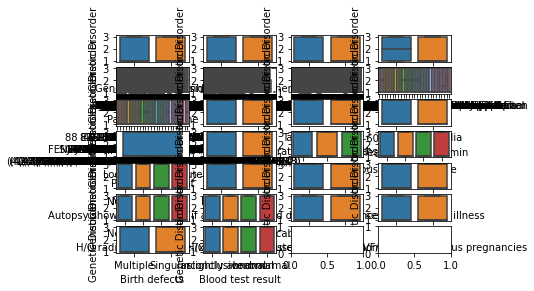

In [92]:
fig, axes = plt.subplots(7, 4, constrained_layout=True) # create figure and axes

for i, el in enumerate(cat):
    sns.boxplot(X_train[el], y_train, ax=axes.flatten()[i])
    
plt.tight_layout() 
plt.show()

<AxesSubplot:xlabel="Genes in mother's side", ylabel='Genetic Disorder'>

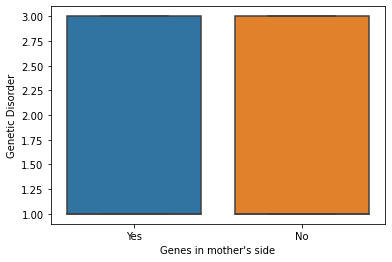

In [87]:
sns.boxplot(X_train[cat[0]], y_train)

<AxesSubplot:xlabel='Inherited from father', ylabel='Genetic Disorder'>

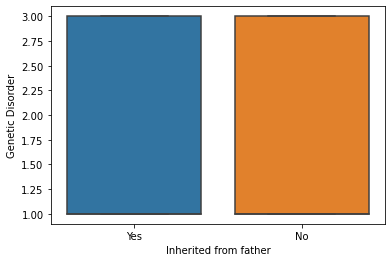

In [88]:
sns.boxplot(X_train[cat[1]], y_train)

### Important variables we derived:
#### Numerical:
- wind_speed(m/s)
- shaft_temperature(°C)
- blades_angle(°)
- gearbox_temperature(°C)
- engine_temperature(°C)
- motor_torque(N-m)
- generator_temperature(°C)
- area_temperature(°C)
- wind_direction(°)
- resistance(ohm)
- rotor_torque(N-m)
- blade_breadth(m)

#### Categorical
- cloud_level

# Encoding

In [425]:
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['turbine_status', 'cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
20639,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.546609,0.432503,24.812621,1,0
505,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.244555,0.237205,16.311905,0,0
18039,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-99.000000,0.467374,24.622301,0,0
16785,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.455391,0.449980,26.400075,0,0
24401,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.337868,0.437560,24.375441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13210,-107.206822,14.190797,80.688395,-0.692205,137.459567,43.921804,929.826193,42.362351,118426.832893,32.415978,20.754016,232.455409,1420.695555,16.786307,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.385628,0.407371,26.490003,1,0
19784,94.146353,17.551073,45.146921,9.648162,48.821965,45.241926,2802.511942,92.887576,18847.194888,39.858219,43.560988,499.761898,1975.706079,47.059900,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.357959,0.335699,27.043789,0,0
9910,41.308615,11.860592,45.693220,11.938051,49.468022,42.891585,934.817779,47.127975,141413.343409,36.924496,45.172467,516.914848,1465.555896,18.252104,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.348490,0.445592,25.164745,1,0
10869,95.722664,26.078089,41.864851,38.798129,39.429732,42.490011,1141.501484,66.925160,16402.040513,33.423691,45.294931,106.899949,1663.606364,-53.173383,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,3.816595,0.383892,25.358264,0,0


In [426]:
X_train.shape, X_test.shape

((27713, 36), (280, 36))

# Feature Scaling

In [427]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [428]:
X_train

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,-0.865787,-0.436489,-6.857725,-0.096096,13.800313,-7.664069,-0.722991,-0.774817,0.986706,-0.662311,-1.309495,-0.116527,-0.602784,-0.613861,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.783077,0.332558,-0.364353,1.0,0.0
1,0.020467,0.176744,0.027299,13.344642,-0.416144,-0.683829,-0.645512,-0.115592,-0.024435,-0.299037,-6.003177,0.996239,-0.026608,-0.208051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.420532,-1.582649,-3.214662,0.0,0.0
2,-0.731602,-0.235061,0.761876,-15.021895,0.644313,0.495091,-0.675332,-0.749335,1.108392,-0.020788,-0.922214,0.621114,-0.447590,-0.592620,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-53.355353,0.674519,-0.428168,0.0,0.0
3,-1.011388,-0.189896,0.404239,-0.092196,0.282506,-0.267305,-0.791428,-0.820107,1.044115,-0.671630,-0.101998,-0.169290,-0.780225,-0.619854,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.212543,0.503948,0.167924,0.0,0.0
4,0.016536,0.539946,-7.984452,6.144555,-8.529500,0.237361,-0.574608,-0.030494,-0.021322,-0.207642,0.060867,0.196535,-0.026486,-0.325893,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.673938,0.382141,-0.510941,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27708,-2.708099,0.001826,9.169400,-0.024907,17.741920,0.121849,-0.692424,-0.751614,1.001623,-0.015293,-0.922214,-0.679351,-0.459469,-0.537369,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.176068,0.086093,0.198077,1.0,0.0
27709,0.012073,0.152900,0.362600,1.552530,1.054896,0.527109,0.485088,0.587864,0.001039,0.668112,0.045447,2.476332,0.530644,0.564437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,-0.361240,-0.616757,0.383763,0.0,0.0
27710,-0.701736,-0.102938,0.497967,1.901856,1.176523,-0.194415,-0.689286,-0.625272,1.232593,0.398715,0.113820,2.678831,-0.379441,-0.484021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-0.366190,0.460915,-0.246285,1.0,0.0
27711,0.033368,0.536264,-0.450662,5.999397,-0.713298,-0.317693,-0.559326,-0.100427,-0.023530,0.077243,0.119016,-2.161594,-0.026128,-3.083547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.401395,-0.144149,-0.181398,0.0,0.0


In [429]:
# necessary functions
from sklearn.decomposition import PCA
labels = np.reshape(train[wind].to_numpy(), (train.shape[0],1))

def pca_analysis(df, n_components):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(df.iloc[:, :-1].values)

    pca_concatenate = np.concatenate([pca_result, labels], axis=1)
    return pca_concatenate
def make_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'pc{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

from sklearn.manifold import TSNE
def tsne_analysis(df, n_components):
    tsne = TSNE(n_components=n_components)
    tsne_result = tsne.fit_transform(df.iloc[:, :-1].values)

    tsne_concatenate = np.concatenate([tsne_result, labels], axis=1)
    return tsne_concatenate
def tsne_dataframe(array, n_features):
    col = []
    for i in range(1, n_features+1):
        col.append(f'tsne{i}')
    col.append(wind)
    return pd.DataFrame(array, columns = col)

# def get_xy(df):
#     if df.shape==37:
#         X = df.drop(wind, axis=1)
#     else:
#         X = df
#     y = train[wind].copy()
#     return X, y
def get_xy(df):
    X = df.drop(wind, axis=1)
    y = train[wind].copy()
    return X, y

# XGB

In [430]:
from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.metrics import accuracy_score, r2_score
import xgboost as xgb
xgb =  xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5,
                       learning_rate = 0.03 , max_depth = 8, n_estimators = 500)

In [431]:
# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

In [432]:
from sklearn.metrics import accuracy_score, r2_score

# rf.score(X_test, y_test)
score = max(0, 100 * r2_score(y_test, y_pred))
score

92.53691684381909

# Test with test.csv

In [433]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,NaN,Medium,3.286975,0.407771,20.888674
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,NaN,0.367823,24.793606
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,NaN,A,Medium,2.247676,0.394680,24.591364


In [434]:
test.isnull().sum()

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64

In [435]:
for c in ['turbine_status','cloud_level']:
    impute_categorical(test, c)

In [436]:
for i in test.columns:
    if test[i].isnull().sum()>0:
        mean = test[i].mean()
        test[i].replace(np.nan, mean, inplace=True)
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,WM_1630,2018-11-12 17:33:20,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,WM_24703,2019-05-27 11:53:20,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,WM_22893,2019-05-13 21:53:20,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [437]:
# X_train_final = train.drop([wind, 'tracking_id', 'datetime'], axis=1)
X_train_final = train3.drop([wind], axis=1)
y_train_final = train3[wind]
X_test_final = test.drop(['tracking_id', 'datetime'], axis=1)


X_train_final.shape, X_test_final.shape

((27993, 21), (12086, 21))

In [438]:
X_test_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431,0,0
1,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,54283.324683,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823,0,0
2,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677,0,0
3,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,54283.324683,23.886434,13.501595,308.376140,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426,0,0
4,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,-15.039400,18.517204,43.545409,-1.094038,44.550547,44.486619,2424.370244,75.850209,17239.345506,28.424722,42.128526,509.795489,1798.141681,-14.365696,BB,Medium,3.286975,0.407771,20.888674,1,0
12082,97.594116,-99.000000,44.747916,1.750553,43.308176,42.848779,2085.627252,73.091866,17131.448669,50.615296,47.353528,345.705839,1680.245230,-7.062661,AB,Low,2.201328,0.367823,24.793606,0,0
12083,16.186805,8.109976,43.252012,-0.691090,214.904165,41.177782,788.687177,39.514258,118707.643665,20.983939,41.768478,205.569627,2343.165194,12.331790,BA,Low,3.728375,0.459887,5.653451,0,0
12084,93.254033,-99.000000,43.841789,-1.171974,41.976913,42.039796,2079.855634,71.482324,17155.269313,29.114305,82.750271,260.578999,1732.883672,26.566581,A,Medium,2.247676,0.394680,24.591364,0,0


In [439]:
X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)
X_train_final

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status_1,turbine_status_2,turbine_status_3,turbine_status_4,turbine_status_5,turbine_status_6,turbine_status_7,turbine_status_8,turbine_status_9,turbine_status_10,turbine_status_11,turbine_status_12,turbine_status_13,turbine_status_14,cloud_level_1,cloud_level_2,cloud_level_3,blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_Imputed,cloud_level_Imputed
0,29.165222,4.441551,16.007962,-1.158862,116.522664,18.559412,881.213471,41.487133,116942.259539,25.369996,11.626132,280.130198,1340.359899,14.684567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.546609,0.432503,24.812621,1,0
1,94.767684,18.081439,43.793750,86.947450,41.008143,41.297332,1004.433697,66.353153,16311.985415,29.326023,-99.000000,374.388573,1663.337042,25.834748,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.244555,0.237205,16.311905,0,0
2,39.097877,8.921827,46.758274,-99.000000,46.641045,45.137630,957.009470,42.448288,129052.691467,32.356140,20.754016,342.613137,1427.354328,15.268205,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-99.000000,0.467374,24.622301,0,0
3,18.387458,9.926404,45.314961,-1.133298,44.719208,42.654147,772.373345,39.778793,122655.688822,25.268513,40.085835,275.660822,1240.895255,14.519918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.455391,0.449980,26.400075,0,0
4,94.476735,26.159988,11.460848,39.749659,-2.088118,44.298081,1117.198016,69.563057,16621.749862,30.321309,43.924408,306.648593,1663.405530,22.596888,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4.337868,0.437560,24.375441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27988,205.877463,-99.000000,42.531312,40.968971,41.649804,42.760867,526.074933,37.237309,114030.753556,28.213448,44.359178,225.944824,1163.440984,-115.027862,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3.794529,0.422523,27.751522,0,0
27989,93.643656,33.617309,44.013938,0.762278,96.679473,41.453165,2147.446711,70.476839,17116.015118,39.558442,43.008021,276.515502,1694.718170,35.347647,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2.211411,0.308142,25.564309,0,0
27990,380.229029,11.722376,43.053466,1.296582,44.788704,44.095178,756.766063,44.522909,77291.728212,29.924312,41.201989,55.865086,1188.992564,12.233934,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4.139110,0.467881,26.306664,0,0
27991,-54.252314,18.640625,41.057651,21.337316,87.649093,42.133972,1531.646898,70.317959,16963.206456,30.778969,41.406119,260.133656,1666.794453,27.841929,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4.332921,0.361095,25.050941,0,0


In [440]:
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

In [441]:
xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)
y_pred_final

array([ 2.6044724,  2.3948421,  3.1894336, ...,  5.1423106,  5.3569455,
       10.906695 ], dtype=float32)

In [442]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

,windmill_generated_power(kW/h)
0,2.604472
1,2.394842
2,3.189434
3,7.425407
4,3.577913
...,...
12081,6.680641
12082,3.301696
12083,5.142311
12084,5.356946


In [443]:
submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)
submission.isnull().sum()

tracking_id                       0
datetime                          0
windmill_generated_power(kW/h)    0
dtype: int64

In [444]:
submission.shape

(12086, 3)

In [445]:
submission.to_csv('submissions/submission_xgb_extended3.1.csv', index=False)

### More tests

In [449]:
imp0 = ['wind_speed(m/s)',
 'shaft_temperature(°C)',
 'blades_angle(°)',
 'gearbox_temperature(°C)',
 'engine_temperature(°C)',
 'motor_torque(N-m)',
 'generator_temperature(°C)',
 'area_temperature(°C)',
 'wind_direction(°)',
 'resistance(ohm)',
 'rotor_torque(N-m)',
 'blade_breadth(m)', 'cloud_level']

imp = ['motor_torque(N-m)', 'blades_angle(°)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'generator_temperature(°C)', 'engine_temperature(°C)']

In [451]:
from sklearn.model_selection import train_test_split
X = train3[imp0]
y = train3[wind]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 0)

X_train.shape, X_test.shape

# Encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['cloud_level'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = RobustScaler()

cols = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


# fit the model
xgb.fit(X_train, y_train)

# Predict the Test set results
y_pred = xgb.predict(X_test)

score = max(0, 100 * r2_score(y_test, y_pred))
score

97.41859670894635

In [453]:
X_train_final = train3[imp0]
y_train_final = train3[wind]
X_test_final = test[imp0]

X_train_final = encoder.fit_transform(X_train_final)
X_test_final = encoder.transform(X_test_final)

X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

X_train_final= pd.DataFrame(X_train_final, columns=[cols])
X_test_final = pd.DataFrame(X_test_final, columns=[cols])

xgb.fit(X_train_final, y_train_final)

# Predict the Test set results
y_pred_final = xgb.predict(X_test_final)

y_pred_final_df = pd.DataFrame(y_pred_final, columns=[wind])
y_pred_final_df

submission = pd.concat([test[['tracking_id', 'datetime']], y_pred_final_df], axis=1)

submission.to_csv('submissions/submission_xgb_extended3.2.csv', index=False)